In [24]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 0.23.4
torch 1.4.0


In [25]:
import torch

import os, wget
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [26]:
from ML.lstm_torch import LSTM_Predictor, train_lstm

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [29]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [30]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [31]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [32]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [33]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [34]:
wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

'time_series_19-covid-Confirmed.csv'

In [35]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [36]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,197,238,428,566,673,790,900,1030,1183


In [79]:
df = df.iloc[:, 4:]

In [80]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,2,3,5,7,8,8,14,14,14,19,...,50,50,53,59,70,75,82,114,147,177
1,2,1,2,2,4,4,7,7,11,15,...,502,511,581,639,639,701,773,839,825,878
2,0,1,3,3,4,5,7,7,10,13,...,150,150,160,178,178,200,212,226,243,266
3,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,3,4,4,4,7,8,8,...,99,117,129,149,149,197,238,428,566,673


In [81]:
df.isnull().sum().sum()

0

In [82]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

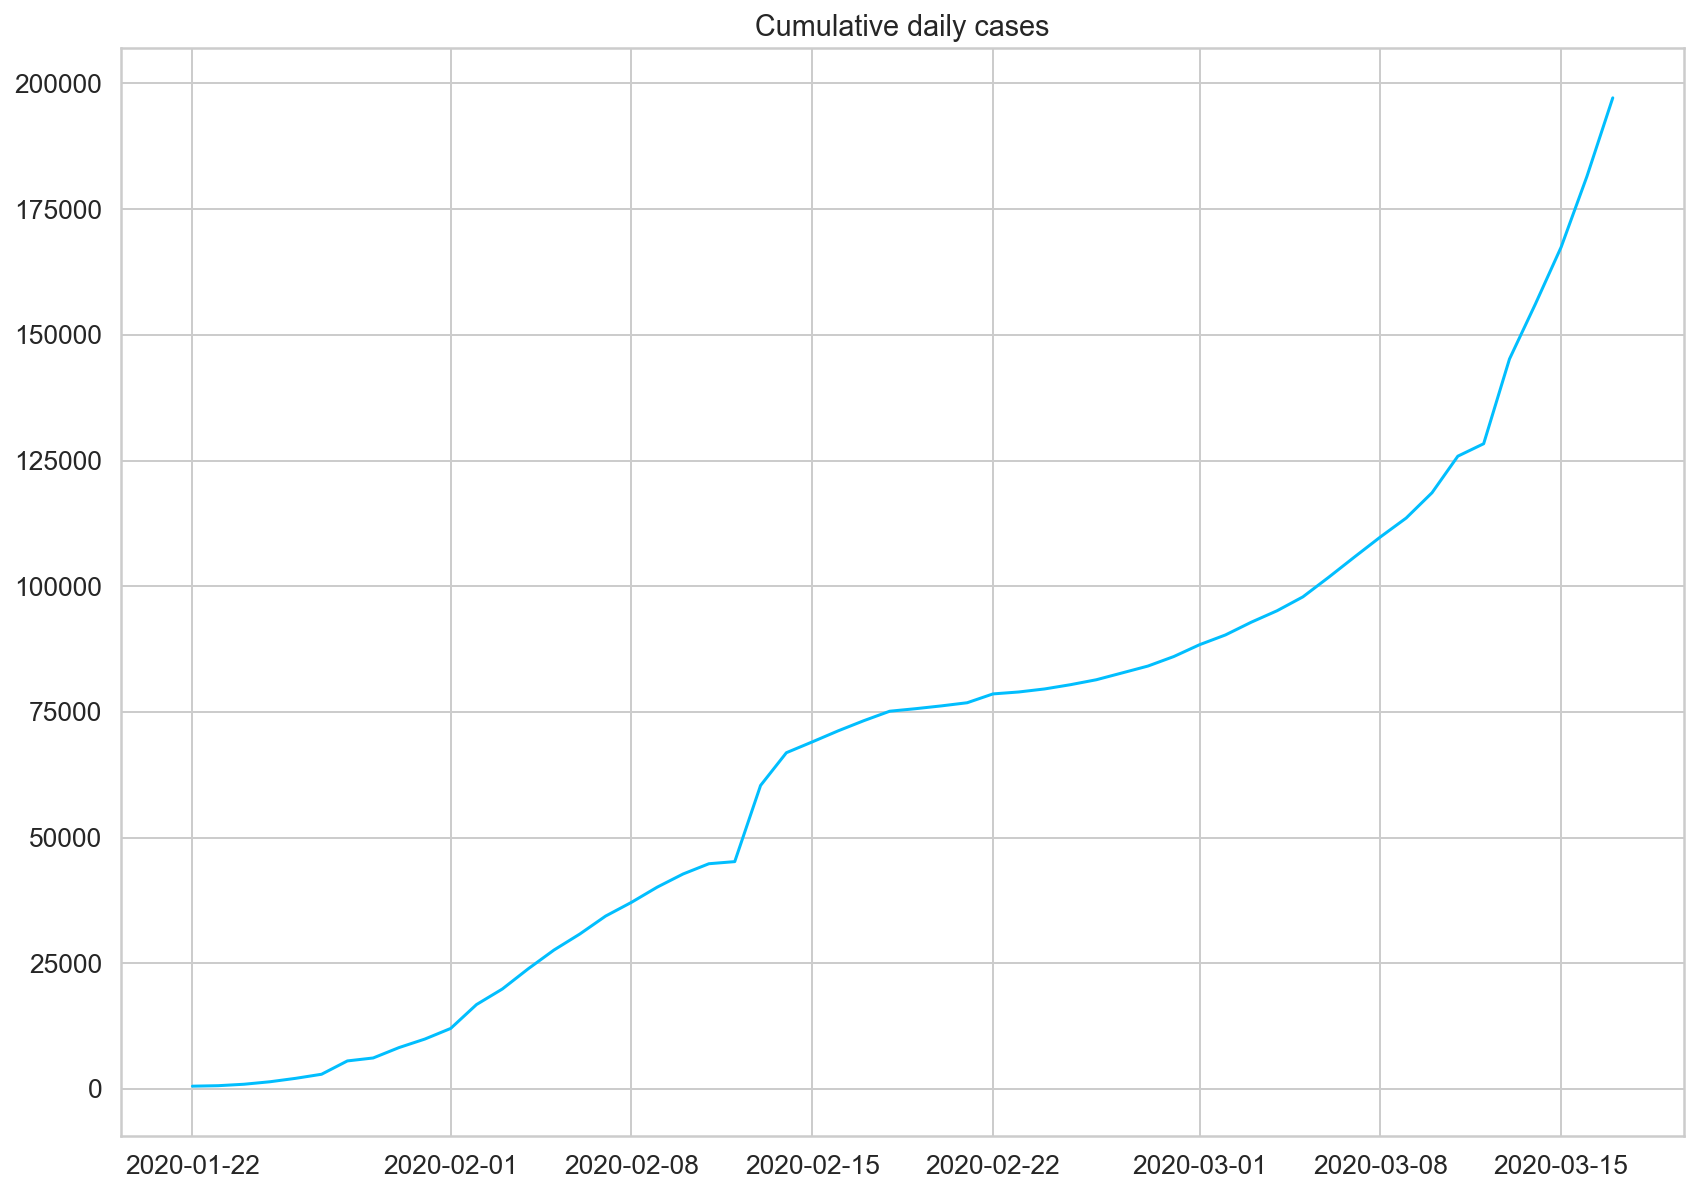

In [83]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [84]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
cumulative_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Daily cases')

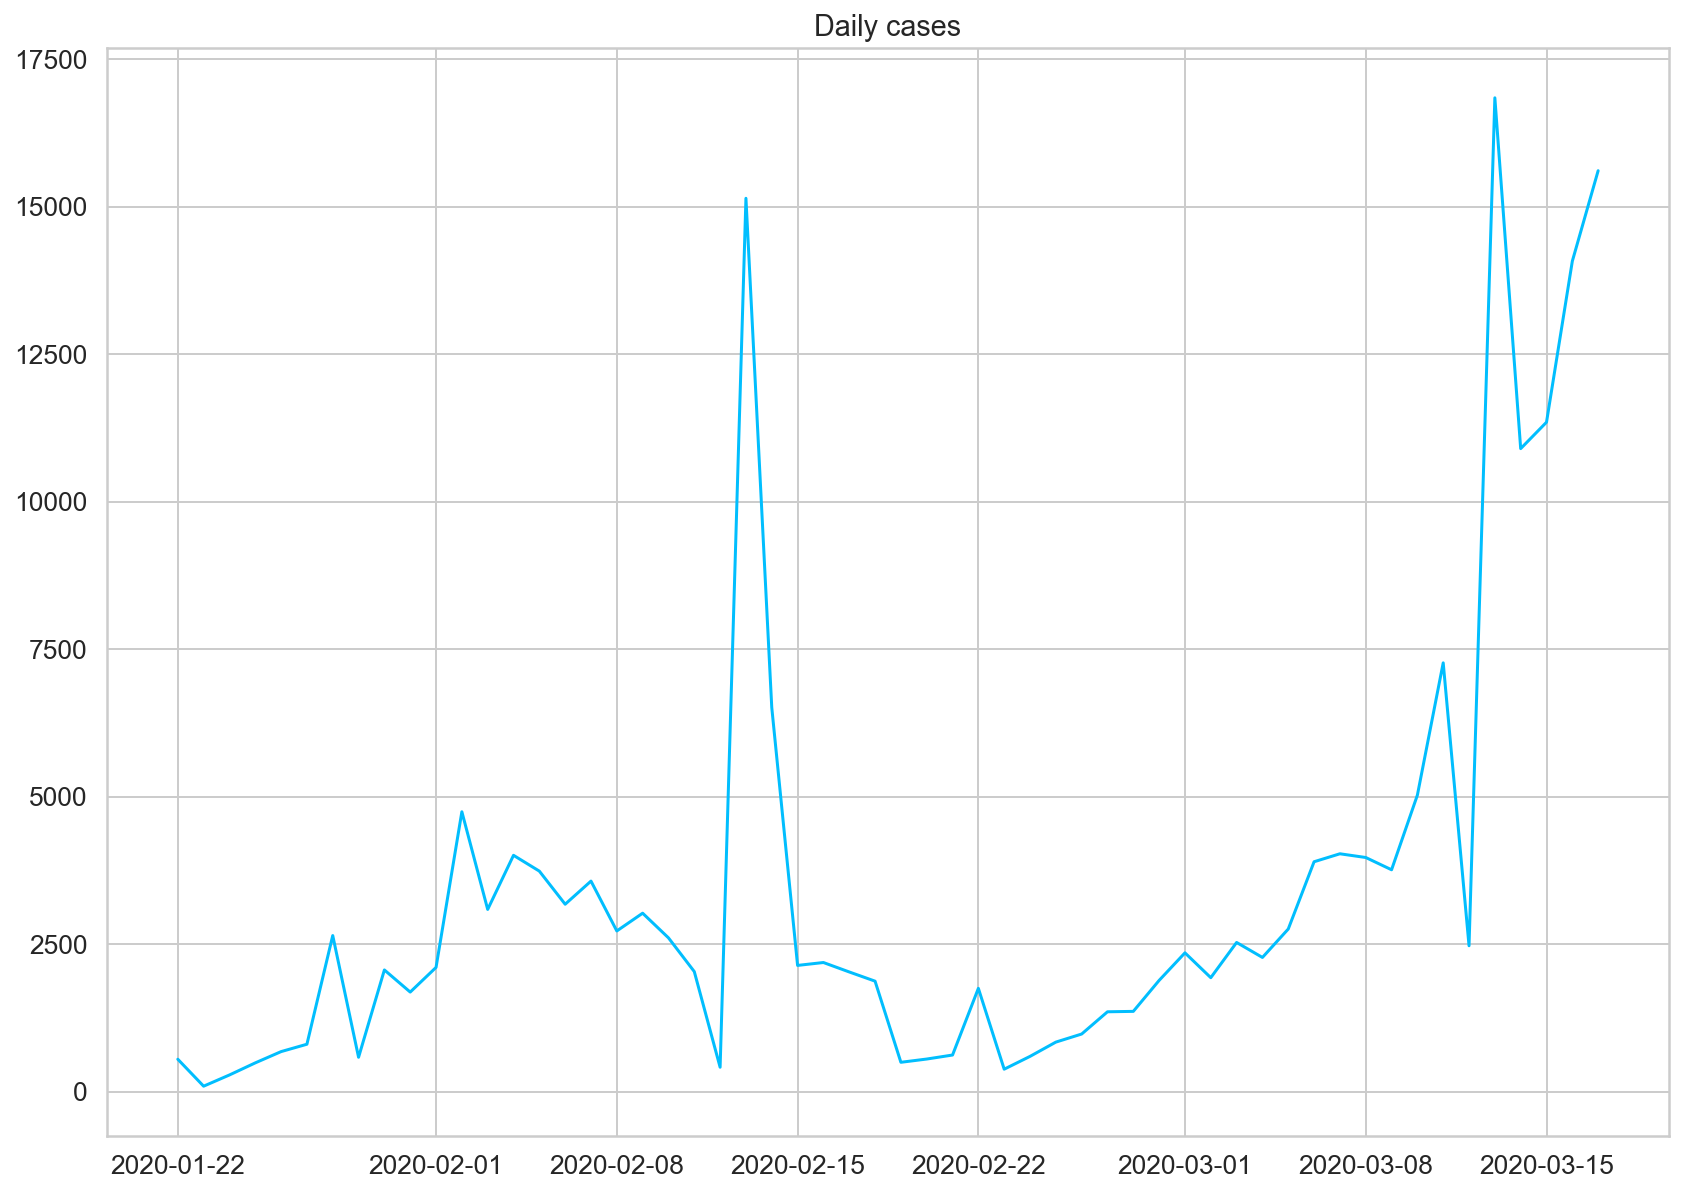

In [85]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [86]:
cumulative_cases.shape

(56,)

In [93]:
test_data_size = 10

train_data = cumulative_cases[:-test_data_size]
test_data = cumulative_cases[-test_data_size:]

train_data.shape

(46,)

In [94]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [95]:
train_data.shape

(46, 1)

In [96]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [97]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [199]:
y_train[:2]

tensor([[0.0225],
        [0.0477]])

In [47]:
def set_seq(d, seq_len):
    xs = []
    ys = []

    for i in range(len(d)-seq_len-1):
        x = d[i:(i+seq_len)]
        y = d[i+seq_len]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [48]:
seq_length = 3
X_train, y_train = set_seq(train_data, seq_length)
X_test, y_test = set_seq(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [49]:
X_train.shape

torch.Size([42, 3, 1])

In [50]:
X_train[:2]

tensor([[[0.0000],
         [0.0009],
         [0.0037]],

        [[0.0009],
         [0.0037],
         [0.0084]]])

In [51]:
y_train.shape

torch.Size([42, 1])

In [52]:
y_train[:2]

tensor([[0.0084],
        [0.0148]])

In [53]:
y_test.shape

torch.Size([6, 1])

In [54]:
train_data[:10]

array([[0.        ],
       [0.00093097],
       [0.0036669 ],
       [0.00835027],
       [0.0148481 ],
       [0.02253339],
       [0.04771721],
       [0.05330306],
       [0.07294853],
       [0.0890316 ]])

In [90]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.3
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [91]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None, n_epochs=300):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

  train_hist = np.zeros(n_epochs)
  test_hist = np.zeros(n_epochs)

  for t in range(n_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [92]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=3
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 16.2713623046875 test loss: 13.005544662475586
Epoch 10 train loss: 10.246241569519043 test loss: 10.348671913146973
Epoch 20 train loss: 4.148248195648193 test loss: 6.064763069152832
Epoch 30 train loss: 3.925164222717285 test loss: 4.351476192474365
Epoch 40 train loss: 4.025666236877441 test loss: 5.83209228515625
Epoch 50 train loss: 3.8270397186279297 test loss: 4.882473468780518
Epoch 60 train loss: 3.892716407775879 test loss: 5.007318019866943
Epoch 70 train loss: 3.8359336853027344 test loss: 5.09738302230835
Epoch 80 train loss: 3.6933581829071045 test loss: 4.9164838790893555
Epoch 90 train loss: 3.812808036804199 test loss: 5.021903038024902
Epoch 100 train loss: 3.7399673461914062 test loss: 4.921476364135742
Epoch 110 train loss: 3.688607692718506 test loss: 4.942474365234375
Epoch 120 train loss: 3.6506435871124268 test loss: 4.8502044677734375
Epoch 130 train loss: 3.6514034271240234 test loss: 4.832076549530029
Epoch 140 train loss: 3.6317565441131

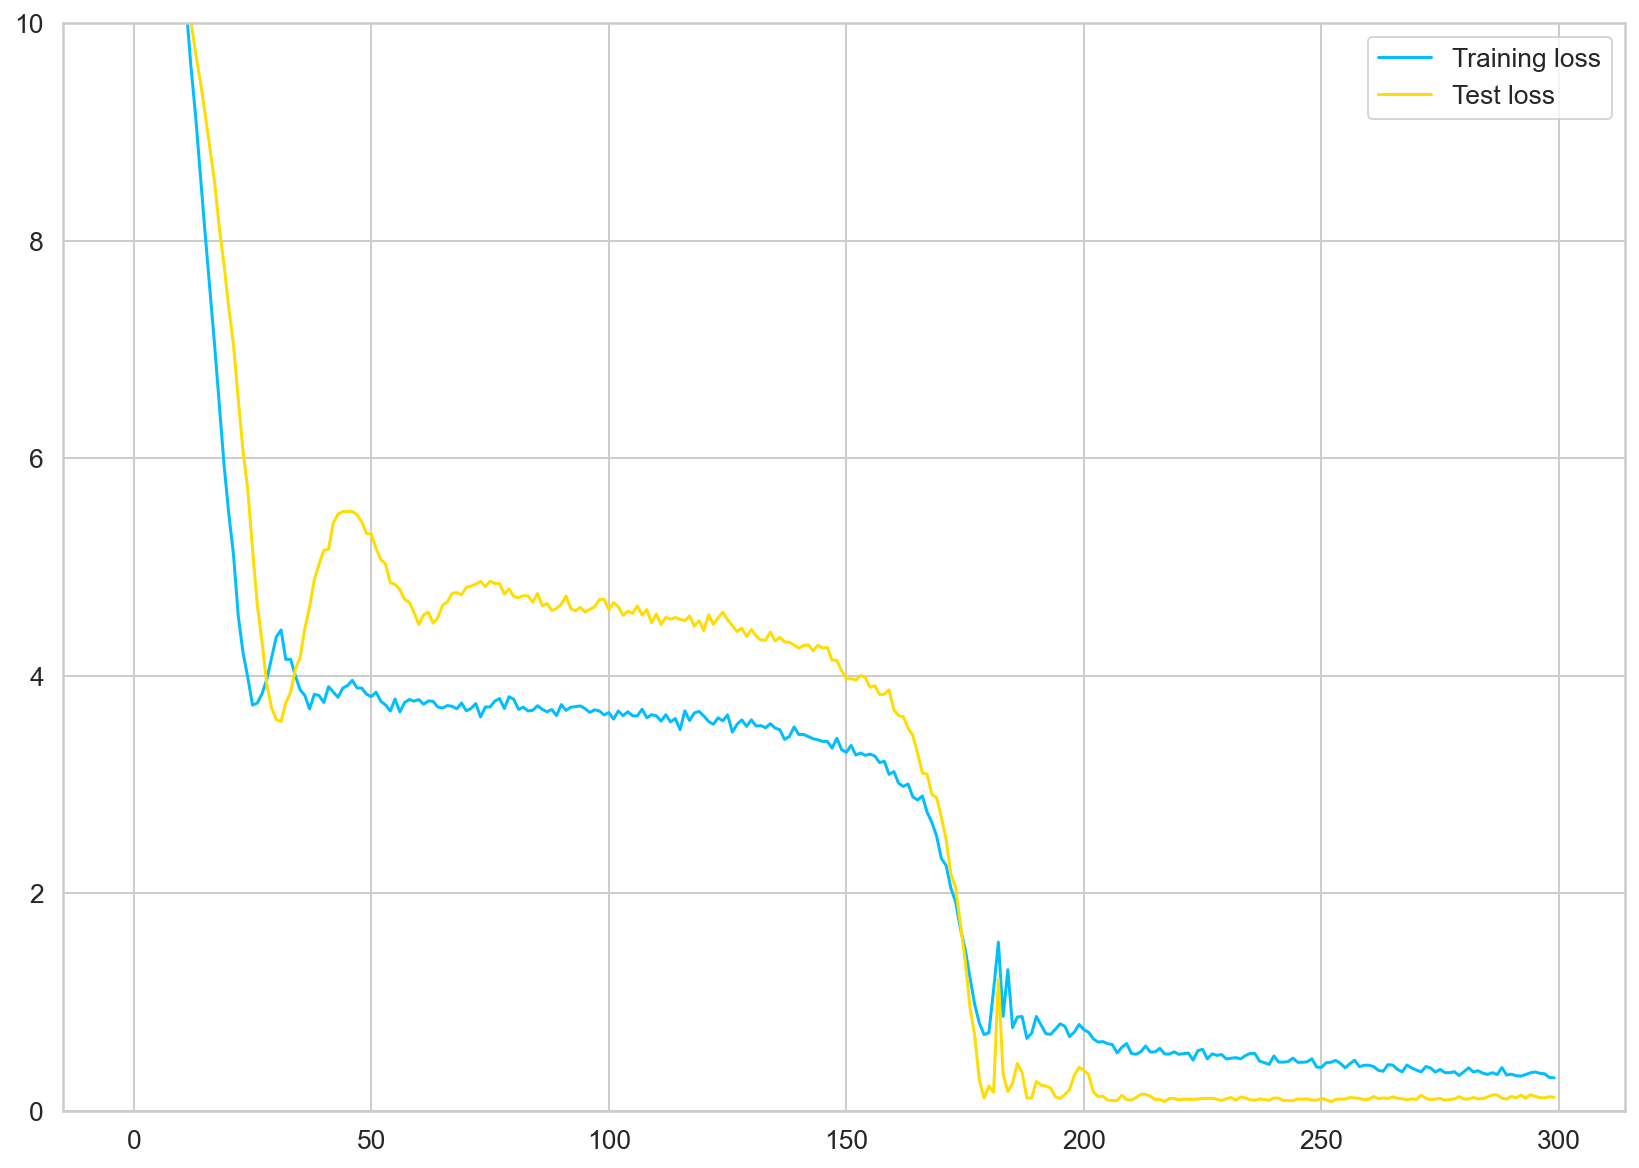

In [58]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [59]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

tensor([[[1.0378],
         [1.0735],
         [1.1213]]])
tensor([[[1.0735],
         [1.1213],
         [1.5653]]])
tensor([[[1.1213],
         [1.5653],
         [1.6292]]])
tensor([[[1.5653],
         [1.6292],
         [1.6916]]])
tensor([[[1.6292],
         [1.6916],
         [1.7521]]])
tensor([[[1.6916],
         [1.7521],
         [1.8101]]])
tensor([[[1.7521],
         [1.8101],
         [1.8650]]])


In [60]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [61]:
true_cases

array([125865.01, 128343.01, 145193.  , 156097.02, 167449.  , 181531.  ],
      dtype=float32)

In [62]:
predicted_cases

array([165328.91005588, 172053.91351986, 178627.52964711, 184995.58576417,
       191097.64740372, 196880.19442391])

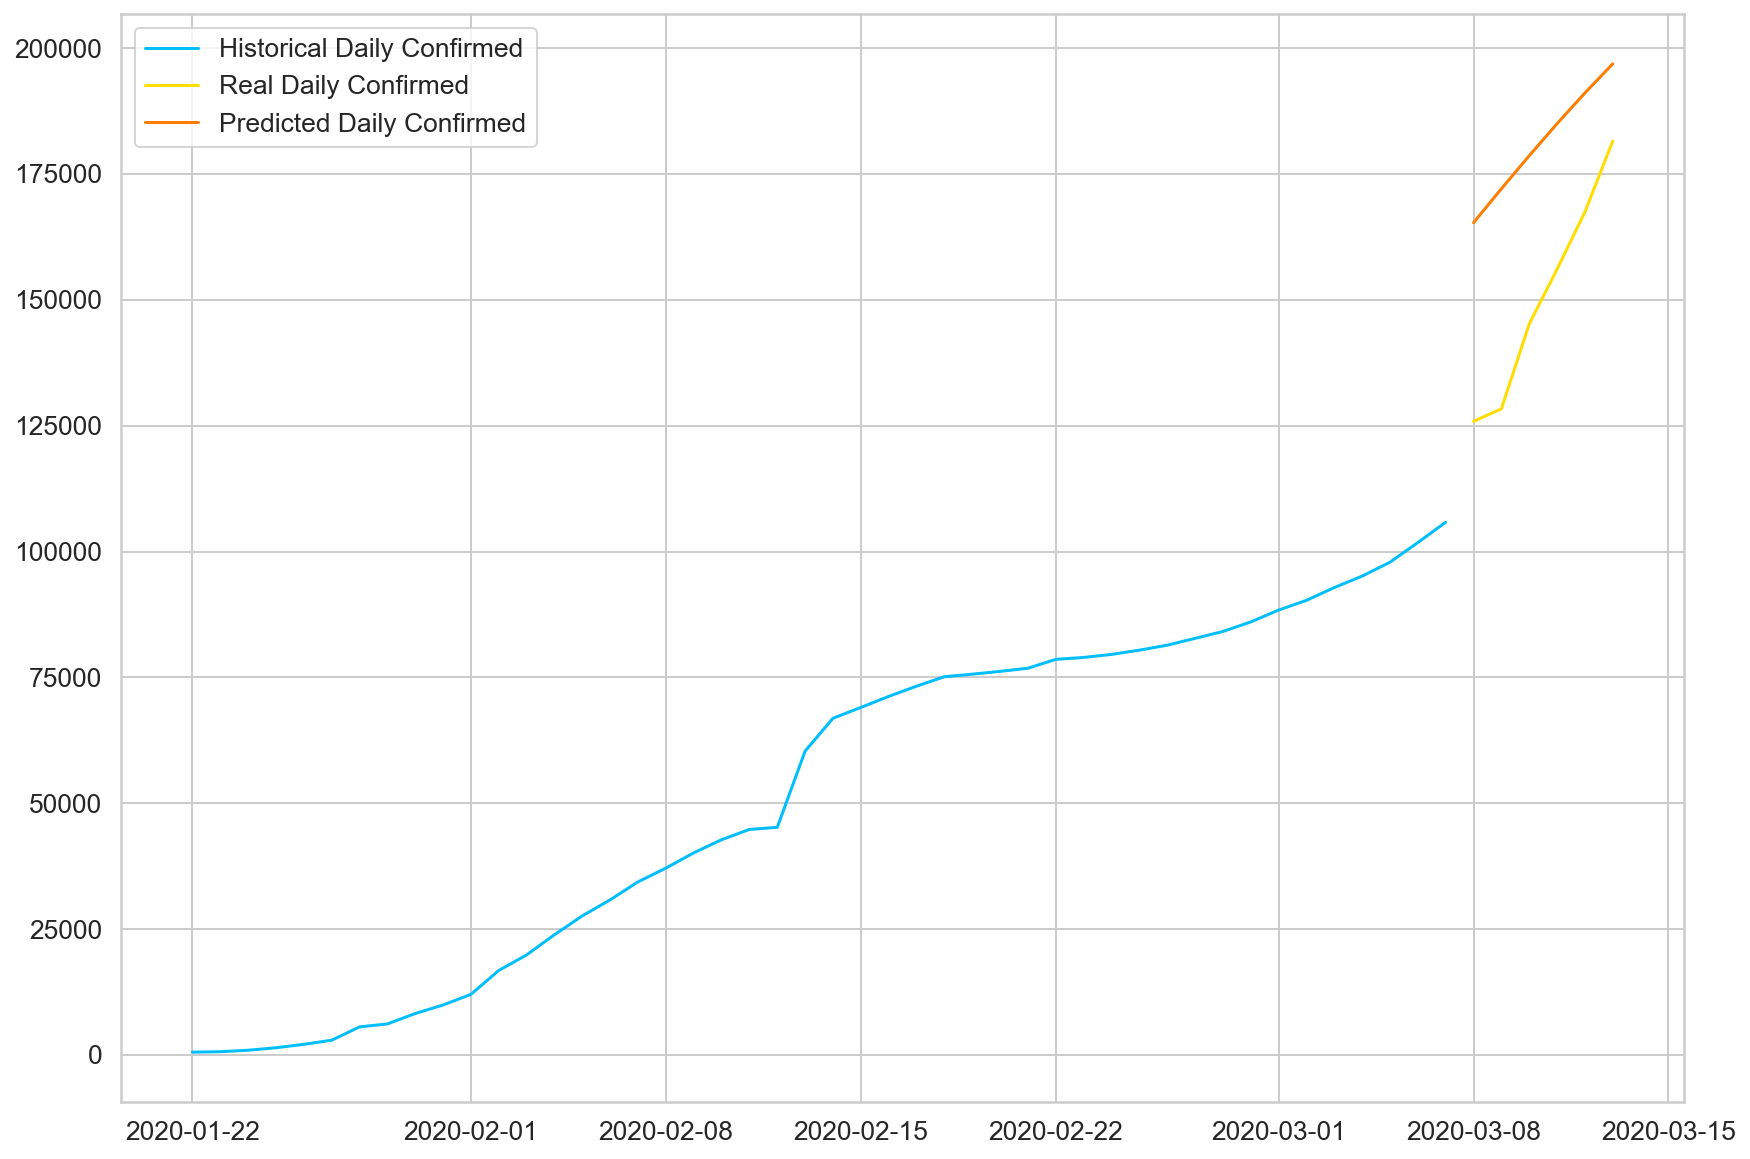

In [63]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## Confirmed

In [1054]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [1055]:
df = df.iloc[:, 4:]

In [1056]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [1057]:
cumulative_cases = daily_cases
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
cumulative_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

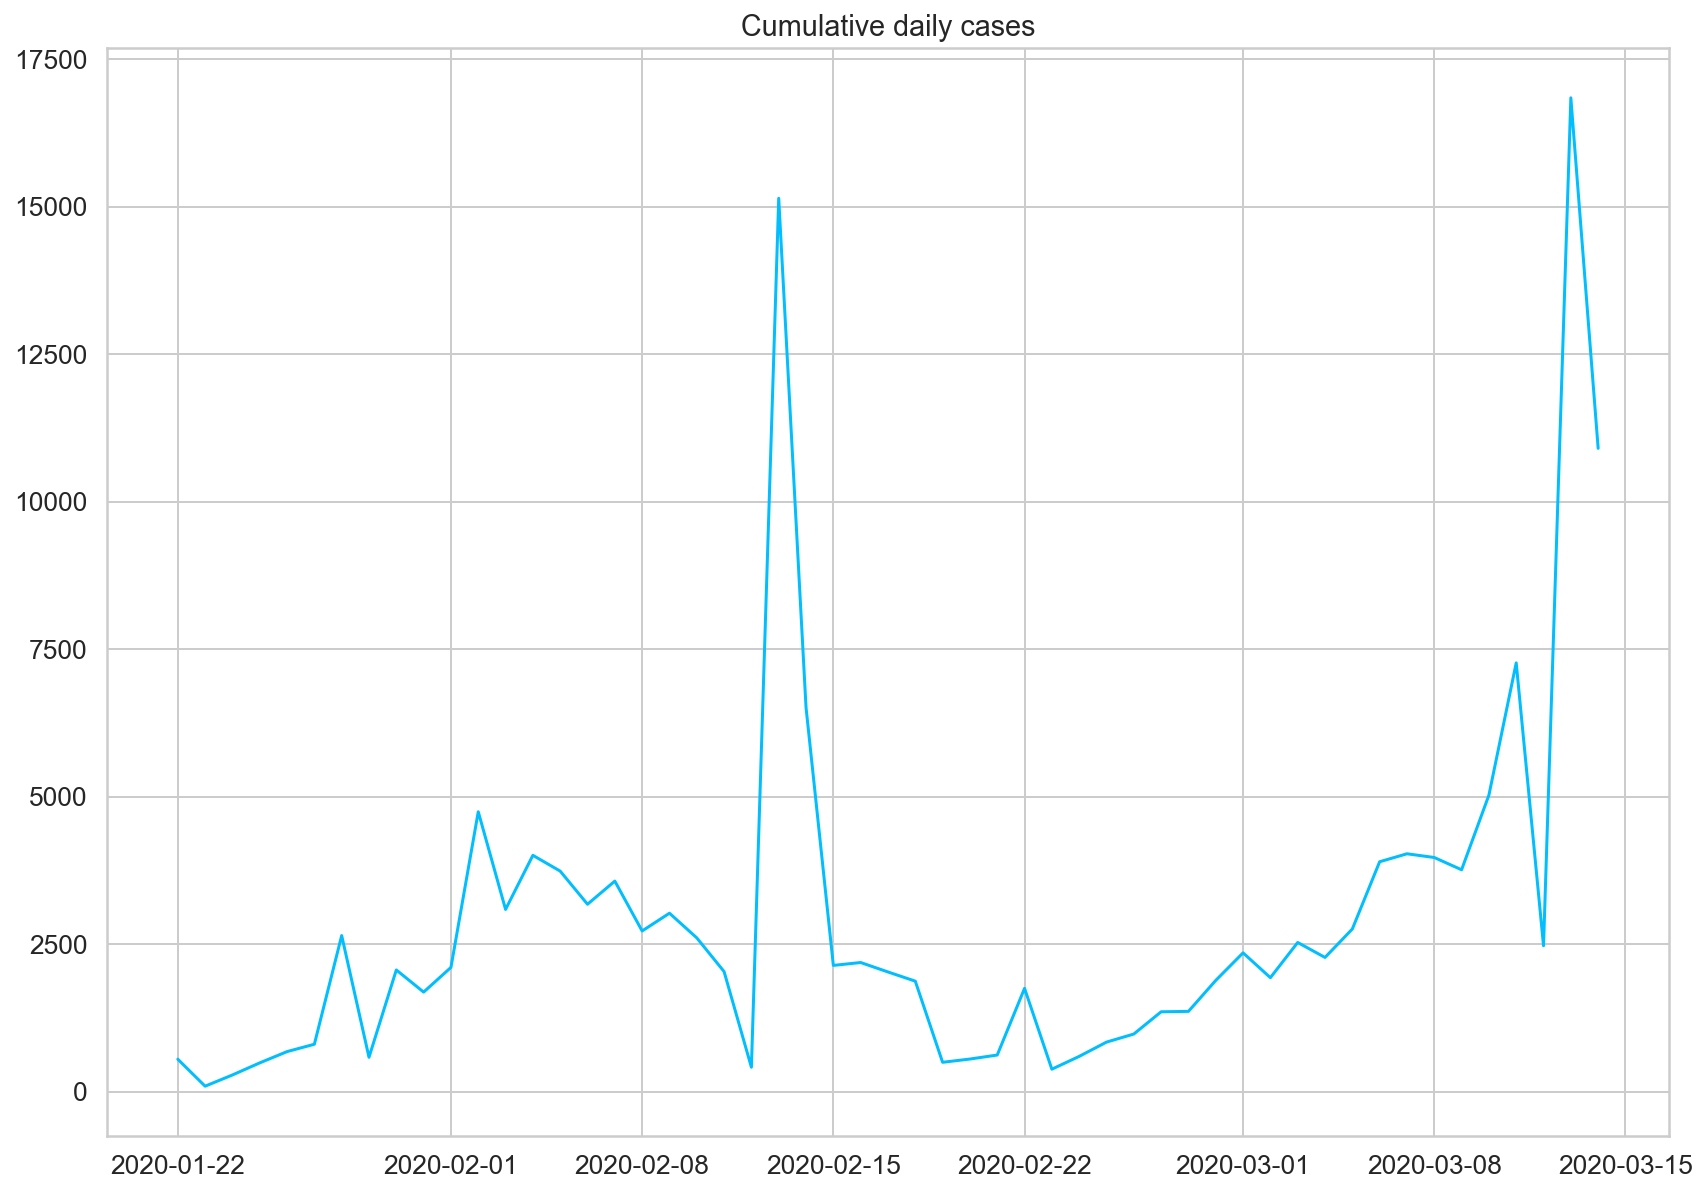

In [1058]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [1059]:
test_data_size = 7

train_data = cumulative_cases[:-test_data_size]
test_data = cumulative_cases[-test_data_size:]

train_data.shape

(46,)

In [1060]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [1061]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [1062]:
seq_length = 3
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [1086]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test,
    n_epochs=500
)

Epoch 0 train loss: 15.286887168884277 test loss: 4.862613677978516
Epoch 10 train loss: 10.15147590637207 test loss: 3.8714609146118164
Epoch 20 train loss: 5.072874069213867 test loss: 2.507732629776001
Epoch 30 train loss: 4.3399658203125 test loss: 1.1271247863769531
Epoch 40 train loss: 3.885362148284912 test loss: 1.7592428922653198
Epoch 50 train loss: 3.833305835723877 test loss: 1.7623302936553955
Epoch 60 train loss: 3.686668634414673 test loss: 1.4921674728393555
Epoch 70 train loss: 3.721796751022339 test loss: 1.5875359773635864
Epoch 80 train loss: 3.6853861808776855 test loss: 1.579279899597168
Epoch 90 train loss: 3.7238826751708984 test loss: 1.538783073425293
Epoch 100 train loss: 3.6790127754211426 test loss: 1.5531086921691895
Epoch 110 train loss: 3.6448886394500732 test loss: 1.559169888496399
Epoch 120 train loss: 3.603729724884033 test loss: 1.525421380996704
Epoch 130 train loss: 3.5243053436279297 test loss: 1.4692728519439697
Epoch 140 train loss: 3.536406517

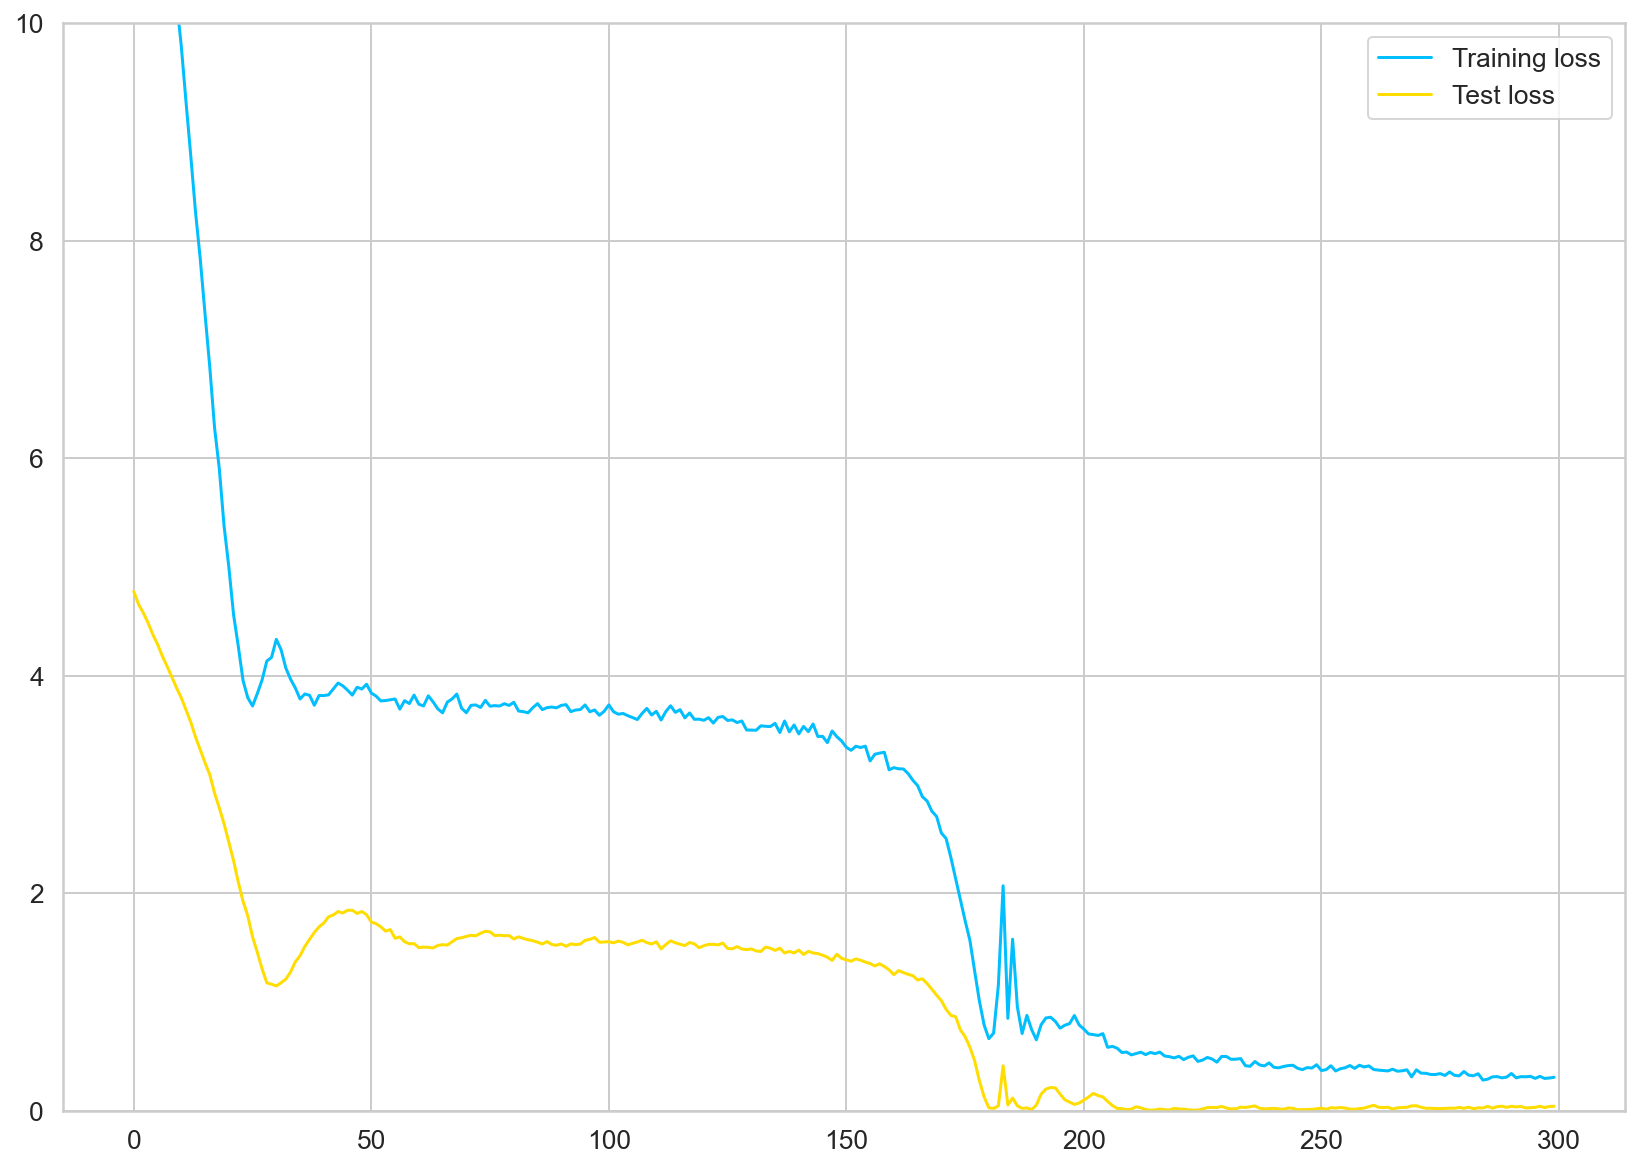

In [1079]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [1080]:
with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        print(test_seq)

tensor([[[1.0378],
         [1.0735],
         [1.1213]]])
tensor([[[1.0735],
         [1.1213],
         [1.3018]]])
tensor([[[1.1213],
         [1.3018],
         [1.3763]]])
tensor([[[1.3018],
         [1.3763],
         [1.4506]]])


In [1081]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [1082]:
true_cases

array([125865.01, 128343.01, 145193.  ], dtype=float32)

In [1083]:
predicted_cases

array([137587.65744996, 145435.37921882, 153249.75913143])

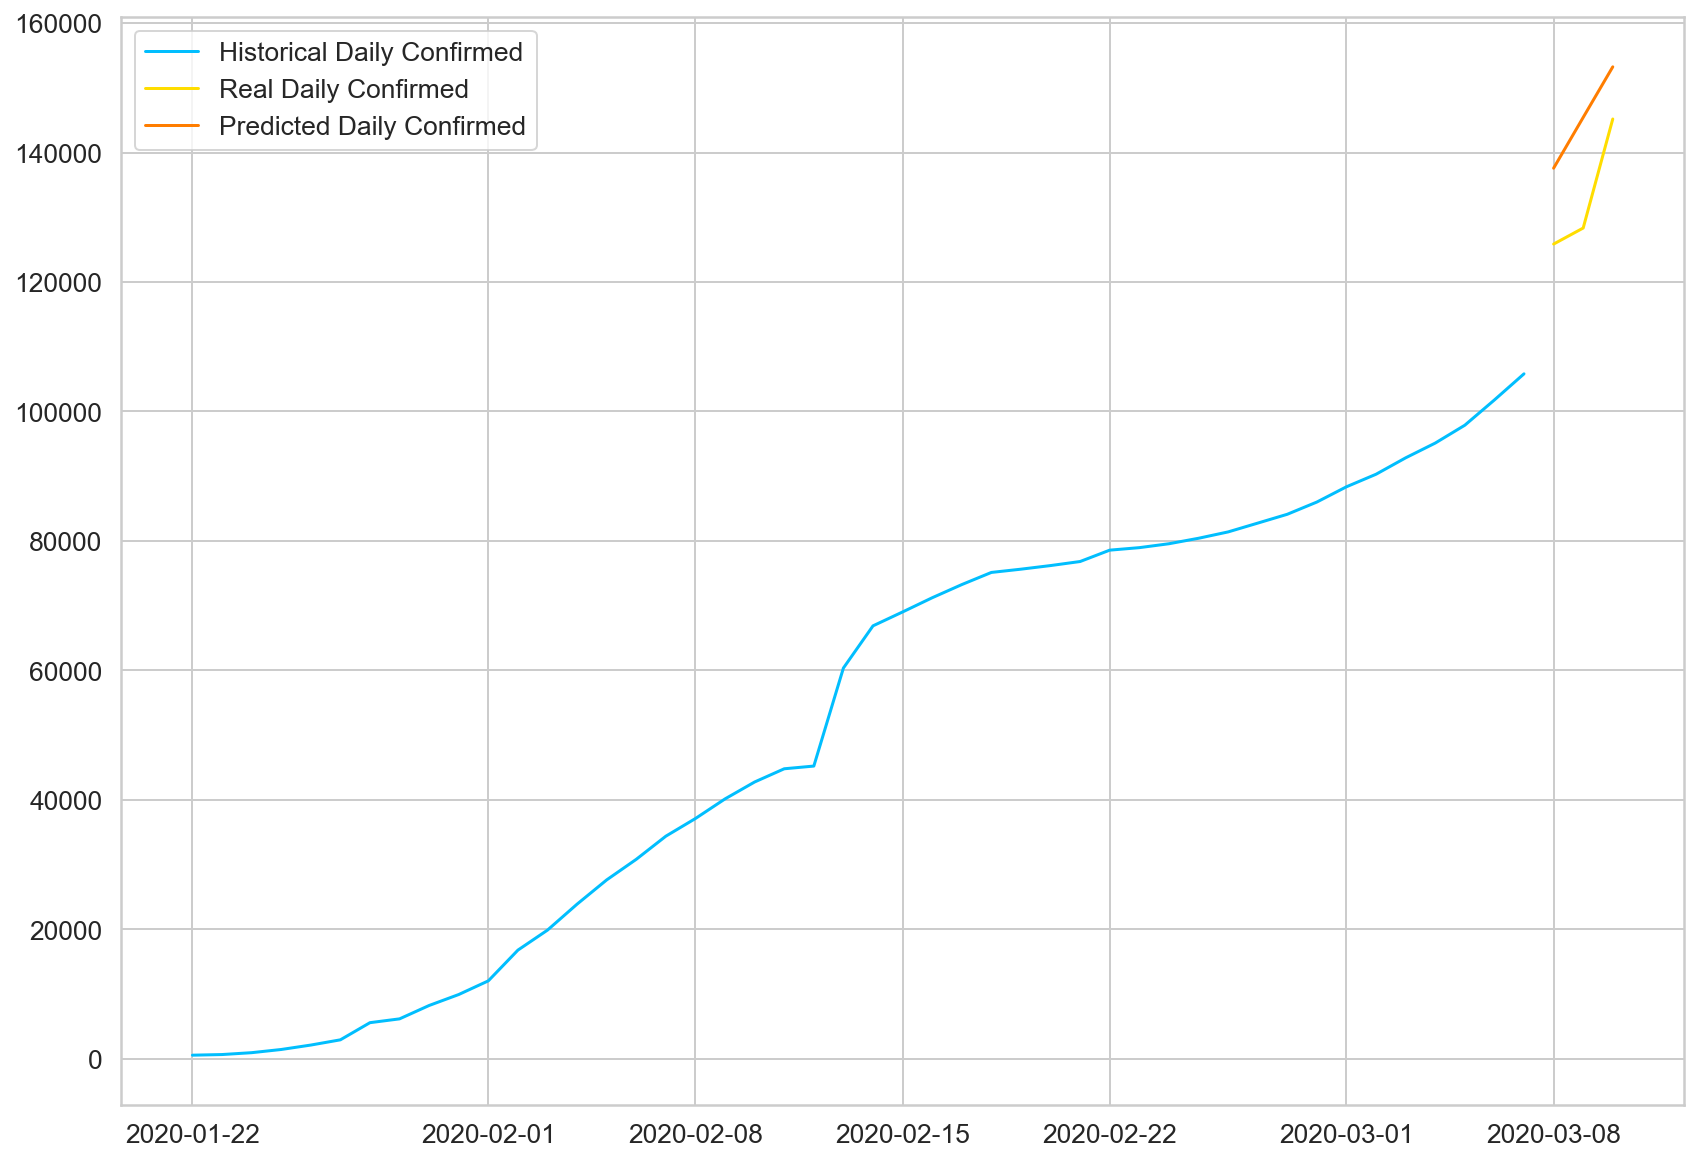

In [1084]:
plt.plot(
  cumulative_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  cumulative_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()